## Mangrove change analysis
- GMW vectors (d/l from here - https://data.unep-wcmc.org/datasets/45 - for now until the geoserver option works)
- select where you want to be in PNG (could change later to geojson input)
- select years of GMW to compare 
- load in vector layers of AOI extent only
- rasterise
- compute change analysis
- interactive display using holoviews for dasky rasters (TODO)

#### Load packages

In [10]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sys
import numpy as np
import xarray as xr
import geopandas as gpd

import datacube
from dea_tools.spatial import xr_rasterize
from dea_tools.plotting import display_map
from datacube.drivers.netcdf import write_dataset_to_netcdf

dc = datacube.Datacube(app='Mangrove change analysis')

#### AWS Access

In [2]:
## Optional: Access AWS "requester-pays" buckets
# This is necessary for Landsat ("landsatN_c2l2_*") and Sentinel-2 ("s2_l2a") products
from datacube.utils.aws import configure_s3_access
configure_s3_access(aws_unsigned=False, requester_pays=True);

### Select Area of Interest (AOI)

In [3]:
from ipyleaflet import Map, basemaps, basemap_to_tiles, DrawControl
from ipywidgets import HTML

# Define the center coordinates of the map
center = (-6.315240, 143.955631)

# Create the map object and set the center and zoom level
m = Map(center=center, zoom=7, basemap=basemap_to_tiles(basemaps.Esri.WorldImagery), scroll_wheel_zoom=True, layout={'height': '800px'})

# Add a label to display the drawn rectangle's coordinates
label = HTML()
m.add_control(label)

latitude = ()
longitude = ()

def handle_draw(self, action, geo_json):
    global latitude, longitude
    coords = geo_json['geometry']['coordinates'][0]
    longitudes, latitudes = zip(*coords)
    min_lat, max_lat = min(latitudes), max(latitudes)
    min_lon, max_lon = min(longitudes), max(longitudes)
    latitude = (min_lat, max_lat)
    longitude = (min_lon, max_lon)
    print(f"Latitude: {latitude}")
    print(f"Longitude: {longitude}")
    self.clear_drawings()
    rect = geo_json['geometry']
    draw_control.add_draw(geo_json['geometry'])

draw_control = DrawControl()
draw_control.polygon = {}  # disable polygon drawing mode
draw_control.polyline = {}  # disable polyline drawing mode
draw_control.circlemarker = {}  # disable circle drawing mode
draw_control.rectangle = {
    "shapeOptions": {
        "color": "red",
        "weight": 1,
        "opacity": 1,
        "fillOpacity": 0
    }
}
draw_control.on_draw(handle_draw)

# Add the draw control to the map
m.add_control(draw_control)

# Display the map
m

Map(center=[-6.31524, 143.955631], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

#### Select times for change analysis uing dropdown widget

In [4]:
import ipywidgets as widgets

gmw_1996 = '../data/GMW/gmw_v3_1996_vec.shp'
gmw_2007 = '../data/GMW/gmw_v3_2007_vec.shp'
gmw_2008 = '../data/GMW/gmw_v3_2008_vec.shp'
gmw_2009 = '../data/GMW/gmw_v3_2009_vec.shp'
gmw_2010 = '../data/GMW/gmw_v3_2010_vec.shp'
gmw_2015 = '../data/GMW/gmw_v3_2015_vec.shp'
gmw_2016 = '../data/GMW/gmw_v3_2016_vec.shp'
gmw_2017 = '../data/GMW/gmw_v3_2017_vec.shp'
gmw_2018 = '../data/GMW/gmw_v3_2018_vec.shp'
gmw_2019 = '../data/GMW/gmw_v3_2019_vec.shp'
gmw_2020 = '../data/GMW/gmw_v3_2020_vec.shp'

# Define the list of options for the dropdowns
pre_options = [('GMW 1996', gmw_1996), ('GMW 2007', gmw_2007), ('GMW 2008', gmw_2008), ('GMW 2009', gmw_2009), ('GMW 2010', gmw_2010), ('GMW 2015', gmw_2015), ('GMW 2016', gmw_2016), ('GMW 2017', gmw_2017), ('GMW 2018', gmw_2018), ('GMW 2019', gmw_2019), ('GMW 2020', gmw_2020)]
post_options = [('GMW 1996', gmw_1996), ('GMW 2007', gmw_2007), ('GMW 2008', gmw_2008), ('GMW 2009', gmw_2009), ('GMW 2010', gmw_2010), ('GMW 2015', gmw_2015), ('GMW 2016', gmw_2016), ('GMW 2017', gmw_2017), ('GMW 2018', gmw_2018), ('GMW 2019', gmw_2019), ('GMW 2020', gmw_2020)]

# Create the dropdown widgets with the options
pre_dropdown = widgets.Dropdown(options=pre_options, description='Select time 1 mangrove change analysis', style={'description_width': 'initial', 'width': '500px'}, layout=widgets.Layout(width='400px'))
post_dropdown = widgets.Dropdown(options=[], description='Select time 2 mangrove change analysis', style={'description_width': 'initial', 'width': '500px'}, layout=widgets.Layout(width='400px'))

# Define a function to handle the pre selection
def handle_pre_selection(change):
    selected_value = change.new
    # update post dropdown options to only include later dates
    new_post_options = [(option[0], option[1]) for option in post_options if option[1] > selected_value]
    post_dropdown.options = new_post_options
    print(f'You have selected {selected_value}')

# Define a function to handle the post selection
def handle_post_selection(change):
    selected_value = change.new
    print(f'You have selected {selected_value}')

# Attach the functions to the dropdowns
pre_dropdown.observe(handle_pre_selection, names='value')
post_dropdown.observe(handle_post_selection, names='value')

# Display the widgets
display(pre_dropdown)
display(post_dropdown)


Dropdown(description='Select time 1 mangrove change analysis', layout=Layout(width='400px'), options=(('GMW 19…

Dropdown(description='Select time 2 mangrove change analysis', layout=Layout(width='400px'), options=(), style…

#### Load GMW and datacube AOI

In [5]:
# load in mangrove vector data just for AOI extent
bbox = [longitude[0], latitude[1], longitude[1], latitude[0]]

gmw_pre = gpd.read_file(pre_dropdown.value, bbox=bbox)

gmw_post = gpd.read_file(post_dropdown.value, bbox=bbox)

/env/lib/python3.10/site-packages/pygeos/io.py:89: UserWarning: The shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the PyGEOS GEOS version (3.10.2-CAPI-1.16.0). Conversions between both will be slow
  warnings.warn(


In [6]:
# load in some datacube data (to get xarray features to rasterise polygon AOI to)

# set time range to just get some data
time = ('2020-01-01', '2020-01-15')


# load data
ds = dc.load(
    product = 'landsat8_c2l2_sr', 
    latitude = latitude,
    longitude = longitude,
    time=time,
    measurements=['blue', 'green', 'red', 'nir08', 'swir16', 'swir22', 'qa_pixel'],
    output_crs="EPSG:32755",  # Target CRS - https://epsg.io/?q=Papua%20New%20Guinea%20kind%3APROJCRS
    resolution=(30, -30),     # Target resolution
    group_by='solar_day',     # Group by time method
    dask_chunks={'time': 1, 'x': 100, 'y': 100}
)

# rename bands, needed for rgb function and for xr_geomedian
ds = ds.rename({
    "blue": "nbart_blue",
    "green": "nbart_green",
    "red": "nbart_red",
    "nir08": "nbart_nir",
    "swir16": "nbart_swir_1",
    "swir22": "nbart_swir_2",
    "qa_pixel": "fmask",
})


# select out only 1 time step to use in xr_rasterize
ds_AOI = ds.isel(time=0)

In [7]:
# Subset the vector geometries to the area of interest
xmin, ymin, xmax, ymax = bbox

gmw_pre_vec_geom = gmw_pre.cx[xmin:xmax, ymin:ymax]
gmw_post_vec_geom = gmw_post.cx[xmin:xmax, ymin:ymax]

In [8]:
mangrove_t1 = xr_rasterize(gdf=gmw_pre_vec_geom, da=ds_AOI)
mangrove_t2 = xr_rasterize(gdf=gmw_post_vec_geom, da=ds_AOI)

# multiple mangrove_t2 by 10 so addition of xarrays gives unique values of change
mangrove_t2 = mangrove_t2 * 10

# add datasets together to get change
mangrove_change = mangrove_t1 + mangrove_t2

# change values to represent: 0 = no mangrove, 1 = loss of mangrove area, 2 = no change in mangrove area, 3 = gain of mangrove area
mangrove_change = mangrove_change.where(mangrove_change != 11, 2) # replace 11 with 2
mangrove_change = mangrove_change.where(mangrove_change != 10, 3) # replace 10 with 3
mangrove_change = mangrove_change.where(mangrove_change != 0, 0) # replace 0 with 0
mangrove_change = mangrove_change.where(mangrove_change != 1, 1) # replace 1 with 1


### display mangrove change

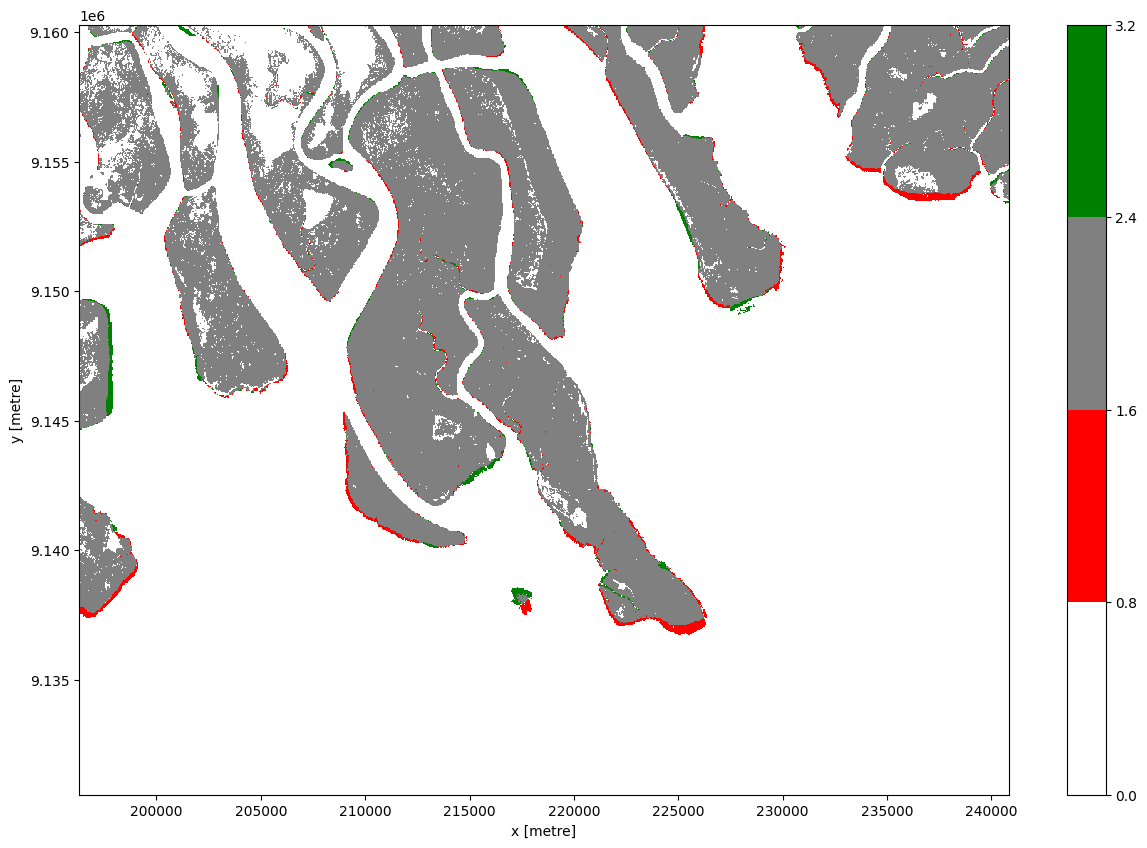

In [16]:
# Define the custom colormap
cmap = colors.ListedColormap(['white', 'red', 'grey', 'green'])

# Create a figure with a specified size
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the data using the custom colormap
mappable = mangrove_change.plot(cmap=cmap, levels=5, ax=ax)

# Show the plot
plt.show()


#### export

In [ ]:

# AOI_mangrove_ds = AOI_mangrove.to_dataset(name="mangrove").squeeze()
# AOI_mangrove_ds

# # export out as .nc to allow load back in easily as xarray
# write_dataset_to_netcdf(AOI_mangrove_ds, '../data/mangrove_2020_test.nc')

In [ ]:
# from datacube.utils.cog import write_cog
# # add crs and to_array for cog output
# mangrove_t1.attrs['crs'] = 'EPSG:32755'
# # mangrove_export = mangrove_t1.to_array()

# # output as cog
# write_cog(mangrove_t1, '../data/mangrove_t1.tif', overwrite=True)